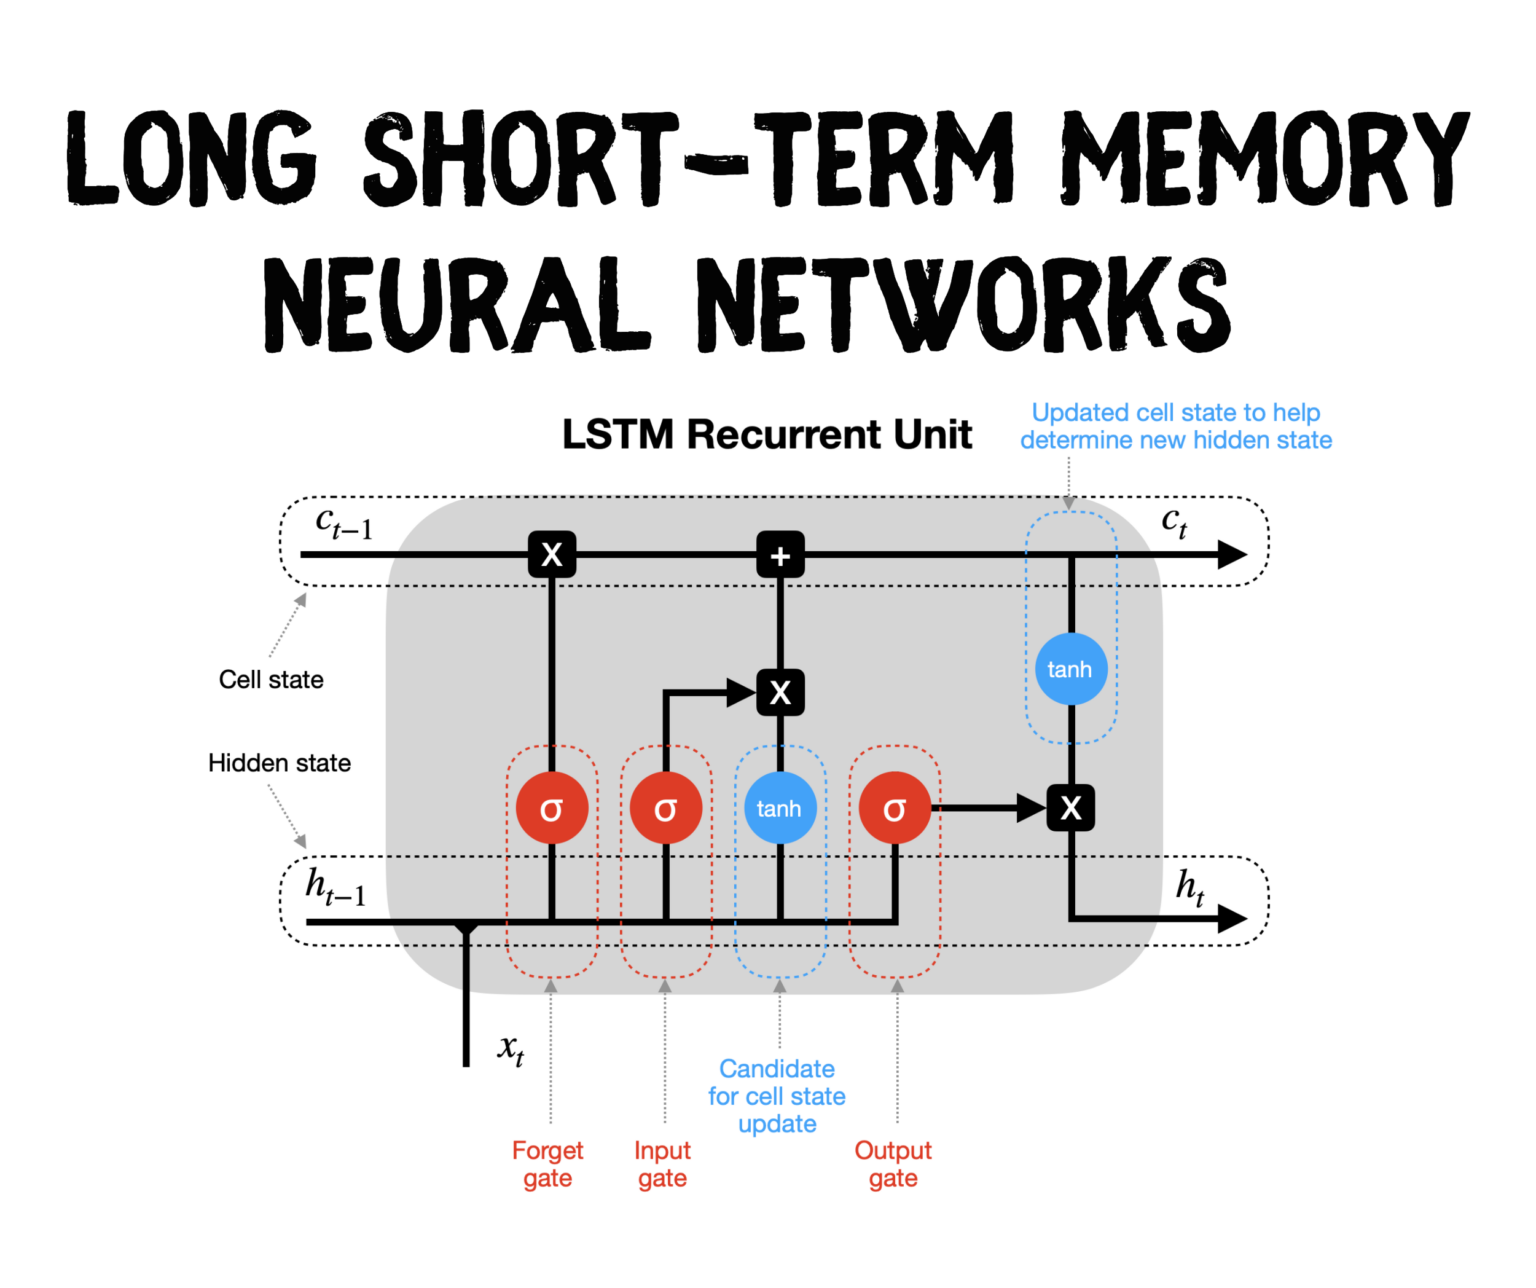!
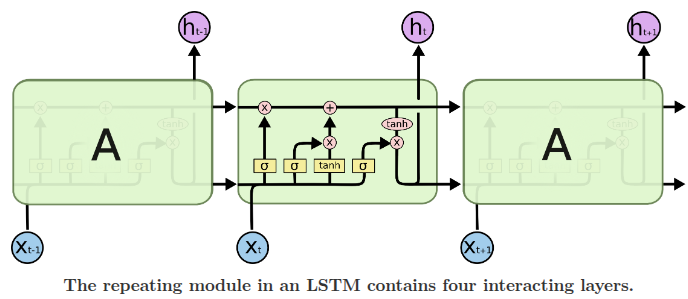

In [1]:
%matplotlib widget

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime

2025-12-22 16:37:35.708539: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-22 16:37:35.721459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766439455.737287   27081 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766439455.741884   27081 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-22 16:37:35.757441: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:
!

In [2]:
df = pd.read_csv('daily-min-temperatures.csv', usecols=[1])

data = df.values.astype('float32')
df.head()

,Daily minimum temperatures
0,20.7
1,17.9
2,18.8
3,14.6
4,15.8


In [3]:
# fechas a partir de los indices
datetime_values = [datetime.datetime(1985,1,1)+datetime.timedelta(days=i) 
                   for i in range(len(data))]

In [24]:
# Normalizamos 
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)


# look_back features: datos previos (pasado) 
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


look_back = 30 # 30 dias previos
X, Y = create_dataset(data_scaled, look_back)

# features :[Muestras/Pasos de Tiempo, Características]
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

# train test
train_size = int(len(X) * 0.80)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]
times_test = datetime_values[train_size:len(Y)]
# lstm
model = Sequential()
# Capa oculta 50 neuronas
model.add(LSTM(50, input_shape=(1, look_back)))
# Capa de salida (1 solo valor: la temperatura predicha)
model.add(Dense(1))
# adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

print("training model...")
history = model.fit(trainX, trainY, epochs=20, batch_size=32, verbose=1)

# predict: train and test
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# norm invert. to celcius
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])


# Desplazamiento para predicciones de entrenamiento
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
# index adjust
start_idx = len(trainPredict) + (look_back * 2) + 1

# final : +
end_idx = start_idx + len(testPredict)
if end_idx > len(data_scaled):
    diff = end_idx - len(data_scaled)
    start_idx -= diff
    end_idx -= diff

testPredictPlot[start_idx:end_idx, :] = testPredict
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data_scaled)-1, :] = testPredict

training model...
Epoch 1/20


/home/aldo/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0736
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 13/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092
Epoch 14/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 15/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 16/20
91/91 ━━━━━━━━━━━━

In [43]:
trainPredictPlot.shape

(3650, 1)

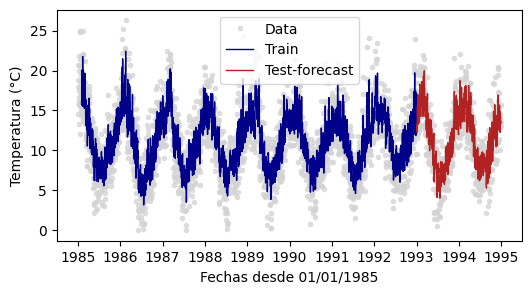

In [37]:
fig = plt.figure(figsize=(6,3))

plt.plot(datetime_values, scaler.inverse_transform(data_scaled),"o",markersize=3, label='Data', color='lightgrey', alpha=0.7)
plt.plot(datetime_values, trainPredictPlot, label='Train', lw=1,color='darkblue')
plt.plot(datetime_values, testPredictPlot, label='Test-forecast',lw=1, color='firebrick')

#plt.title('Forecast: Temperatura Mínima Diaria usando LSTM')
plt.xlabel('Fechas desde 01/01/1985')
plt.ylabel('Temperatura (°C)')
plt.legend()
#plt.show()



In [38]:
fig.savefig("lstm_forecasting-all.png", dpi=300)

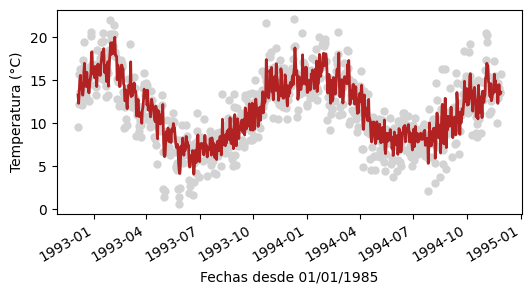

In [39]:
# Only forecast
fig = plt.figure(figsize=(6,3))

#plt.plot(datetime_values, scaler.inverse_transform(data_scaled),"o",markersize=3, label='Data', color='lightgrey', alpha=0.7)
plt.plot(times_test, testY_orig.flatten(), label='Train', lw=0, marker="o", mfc="lightgrey",mec="none",color='darkblue')
plt.plot(times_test, testPredict.flatten(), label='Test-forecast',lw=2, color='firebrick')

#plt.title('Forecast: Temperatura Mínima Diaria usando LSTM')
plt.xlabel('Fechas desde 01/01/1985')
plt.ylabel('Temperatura (°C)')
fig.autofmt_xdate()
#plt.legend()
#plt.show()

In [40]:
fig.savefig("lstm_forecasting_only.png", dpi=300)

In [32]:
plt.close("all")

In [21]:
fig.savefig("lstm_forecasting.png", dpi=300)

Text(0.5, 0, 'Epoch')

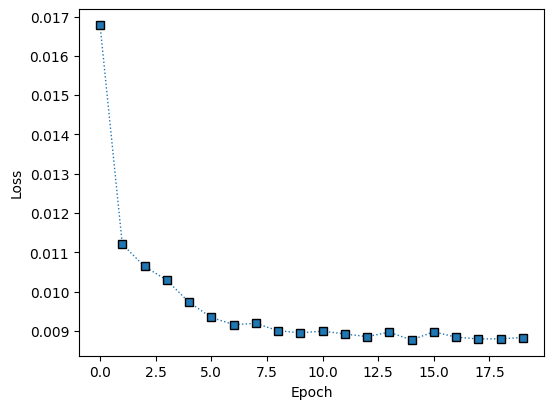

In [6]:
# learning rate
fig = plt.figure(figsize=(6,4.5))
plt.plot(history.history["loss"], "s", ls=":",lw=1,mec="k")
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [29]:
fig.savefig("loss.png", dpi=300)

In [30]:
from sklearn.metrics import mean_squared_error as mse

# metricas

In [9]:
testPredict.shape, testY_orig.reshape()

((724, 1), (1, 724))

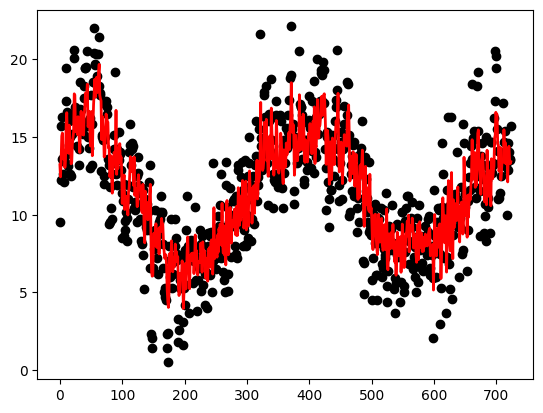

In [15]:
y_pred = testPredict.flatten()
y_true = testY_orig.flatten()
fig= plt.figure()
plt.plot(testY_orig.flatten(), "ok")
plt.plot(testPredict.flatten(), "-r", lw=2)



In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# RMSE (Root Mean Squared Error)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.4f}")

# Pearson Correlation

corr, _ = pearsonr(y_true, y_pred)
print(f"Correlación de Pearson: {corr:.4f}")

RMSE: 2.2131
Correlación de Pearson: 0.8426


In [43]:
# LAGS determined by cross correlation

max_lag=30

lags = range(-max_lag, max_lag + 1)
corrs = []

y_t_norm = (y_true - np.mean(y_true)) / (np.std(y_true) * len(y_true))
y_p_norm = (y_pred - np.mean(y_pred)) / (np.std(y_pred))


correlation = np.correlate(y_t_norm, y_p_norm, mode='same')
mid_point = len(correlation) // 2
relevant_corrs = correlation[mid_point - max_lag : mid_point + max_lag + 1]

# best lag
best_lag = lags[np.argmax(relevant_corrs)]
print(f"El modelo tiene un desfase sistemático de {best_lag} pasos")

El modelo tiene un desfase sistemático de -1 pasos


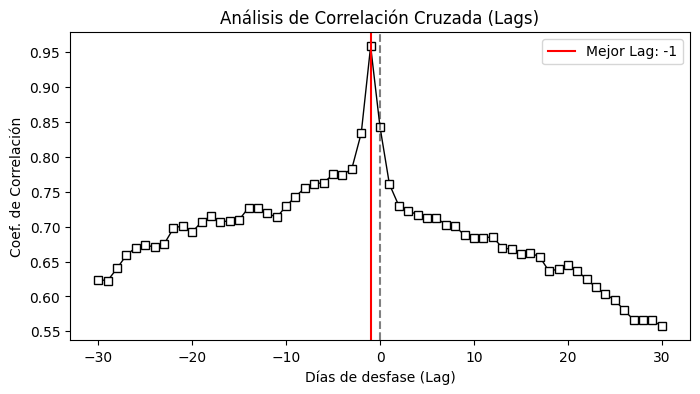

In [44]:
plt.figure(figsize=(8, 4))
#plt.stem(lags, relevant_corrs)
plt.plot(lags, relevant_corrs, color="k", lw=1, marker="s", mfc="white")
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.axvline(best_lag, color='red', linestyle='-', label=f'Mejor Lag: {best_lag}')
plt.title("Análisis de Correlación Cruzada (Lags)")
plt.xlabel("Días de desfase (Lag)")
plt.ylabel("Coef. de Correlación")
plt.legend()
plt.show()
    